In [99]:
from IPython.display import HTML, display
display(HTML("<style>.container { width:95% !important; }</style>"))

In [100]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from interval import interval, inf, imath

In [101]:
# Eq. 25, https://en.wikipedia.org/wiki/Kepler_orbit#Properties_of_trajectory_equation
# Note eq. 24 implies a unique E for all t and 0 < e < 1.
t2E = lambda e, t : fsolve(lambda E : E - e*np.sin(E) - t, t/(1 - e))
circlexy = lambda r, θ : (r*np.cos(θ), r*np.sin(θ))

In [102]:
def xy2q(t, x, y, i, ω, Ω) :   # map orbit to 3D coordinates (x,y) to (q[0],q[1],q[2])
    W = [np.cos(Ω), np.sin(Ω)] # longitude of the ascending node converted to its cosine and sine
    ν = np.sin(i)              # sine of inclination angle
    l = ω + 2*np.pi*t/24/3600  # time (s) converted to orbital plane normal-vector azimuth (radian)
                               # little omega is the arugment of pergigree
    ν = np.array([np.cos(l)*ν, np.sin(l)*ν, np.array([np.cos(i)]*len(l))]).transpose()
                               # ν converted to unit normal vector of orbital plane
    λ = np.cross([0, 0, 1], ν) # vector orthogonal to ν and to reference North Pole
    λ = np.diag(np.sum(λ*λ,axis=1)**-.5)@λ
                               # normalize λ
    μ = np.cross(ν, λ)         # unit vector orthogonal to λ and to ν
    q = (np.diag(x)@λ + np.diag(y)@μ)@np.array([[W[0], -W[1], 0],
                                                [W[1],  W[0], 0],
                                                [   0,     0,  1]])
    return q


In [103]:
def coverage_correction_left(interval_correct):
    # Capture what we need
    left_endpoint = interval_correct[0]
    area_covered = interval([0,left_endpoint[1]])
    # Remove the negative portion of the crossing
    for i in range(1,np.size(interval_correct,0)):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(left_endpoint[0])
    right_int = [2*np.pi - dist_passed, 2*np.pi]
    # Insert interval on the end of area_covered
    # print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

def coverage_correction_right(interval_correct):
    # Capture what we need
    right_endpoint = interval_correct[-1]
    area_covered = interval([right_endpoint[0],2*np.pi])
    # Remove the negative portion of the crossing
    for i in range(0,np.size(interval_correct,0)-1):
        area_covered = interval(area_covered) | interval(interval_correct[i])
    # Capture the crossing on the other part of the interval
    dist_passed = abs(right_endpoint[1])
    right_int = [0, dist_passed - 2*np.pi]
    # Insert interval on the end of area_covered
    # print(area_covered)
    area_covered = interval(area_covered) | interval(right_int)
    return area_covered

In [176]:
def swath_coverage(theta, h):
    swath = (2 * (h/1000) * np.tan( ( (np.pi / 180) / 2 ) * theta ))  
    return swath

In [177]:
# number of days we want to simulate
num_days = .75

# number of satellites we wish to simulate -- << 13
satellites = 1 

# altitude in meters
h = 400000 

# eccentricity
e = .1 

In [178]:
inclination = 1.449          # np.sin takes radians ==> 83° × π/180 = 1.449rad
G = 6.67430e-11              # gravitational constant, m³/(kg s²) https://en.wikipedia.org/wiki/Gravitational_constant
m = [1e3, 5.9722e24]         # masses of satellite, earth, kg https://en.wikipedia.org/wiki/Earth_mass
N = 250                      # nu. plot points
R = 6371.0088e3              # mean earth radius, m https://en.wikipedia.org/wiki/Earth_radius
α = G*sum(m)                 # gravitational parameter, eq. 1, m³/s²
a = (R + h)/(1 - e)          # eq. 35, R + minimum altitude solved for semi-major axis, m
p = a*(1 - e*e)              # eqs. 13--14, r(θ=π/2), θ being the true anomaly
b = a*(1 - e*e)**.5          # eq. 15, semi-minor axis
H = (α*p)**.5                # eq. 26, specific relative angular-momentum magnitude, m²/s
P = 2*np.pi*a**1.5/α**.5     # eq. 43, orbital period for an elliptic orbit, s
opd = (24*60*60) / P         # roughly 16 orbits in one day -- exactly for a period of 1.5 hours
orbits = (num_days)*opd      # number of orbits we will simulate
swath = swath_coverage(30,h) # swath based on calculation of altitude 
s = swath/2                  # half the length
#print(swath,s,opd)

In [179]:
# Setting up parameters needed to find area of
#               swath that crosses the equator
x1 = []
y1 = []
x2 = []
y2 = []
slope = []

In [180]:
# Setting up parameters in order to center a point on an interpolated line at the equator
#       and to calculate the length of the swath crossing the equator, given our angle of  
#                                                                             inclination
u1 = []
v1 = []
a1 = []
b1 = []
hh = []
swath_length = []

In [181]:
# Setting up parameters to track the coverage as we pass the equator
equator_catch_plus  = []
equator_catch_minus = []
interval_caught1    = []
interval_caught2    = []

In [182]:
t = np.linspace(0, orbits*P, 4*N) # time list, s
E = t2E(e, H*t/a/b)               # eq. 25, eccentric anomaly list, radians
x = a*(np.cos(E) - e)             # eq. 20, x-coordinate list
y = b*np.sin(E)                   # eq. 21, y-coordinate list

ω = np.linspace(0,2*np.pi,satellites)   
q = [0]*satellites                # empty array of size # of satellite
for i in range(0,satellites):     # get x,y,z - coords. for each satellite desired
    Ω = np.pi/4 
    q[i] = xy2q(t, x, y, inclination, ω[i], Ω)

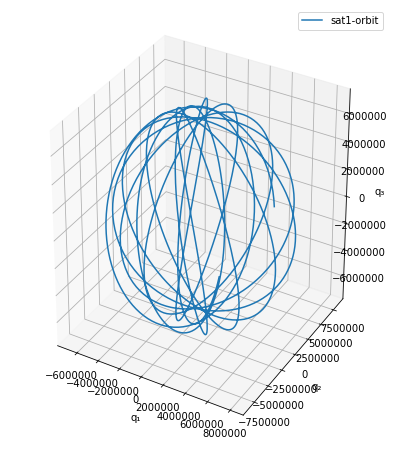

In [183]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,2,1,projection='3d')
for i in range(0,satellites):
    title = "sat" + str(i+1) + "-orbit"
    ax.plot(q[i][:,0], q[i][:,1], q[i][:,2], label=title)
#    ax.plot(q[i][:,0] / 1000, q[i][:,1] / 1000, q[i][:,2] / 1000, label=title) # Change the scale to km?
ax.set_xlabel('q₁')
ax.set_ylabel('q₂')
ax.set_zlabel('q₃')
ax.legend()

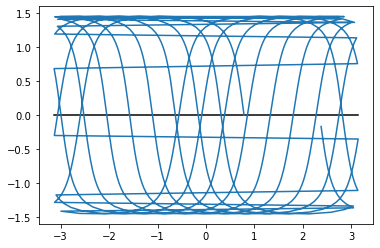

In [184]:
# convert for ground-tracking
psi = [0]*satellites
phi = [0]*satellites

for i in range(0,satellites):
    psi[i] = np.arctan2(q[i][:,0], q[i][:,1]) 
    qq = np.zeros(np.size(q[i][:,2]))
    for j in range(0,np.size(q[i][:,2])):
        qq[j] = q[i][j,2] / np.sqrt( q[i][j,0]**2 + q[i][j,1]**2 + q[i][j,2]**2 )
    phi[i] = np.arcsin( qq )

plt.plot([-np.pi,np.pi],[0,0],c='k') # equitorial line
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])

In [185]:
# Finding when the satellite crosses the equator
#   and accumulating the points to form the line

for i in range(0,satellites):
    for j in range(0,np.size(phi[i])-1):
        if( phi[i][j] > 0 and phi[i][j+1] < 0 ):
            x1.append( psi[i][j] )            # x1
            x2.append( psi[i][j+1] )          # x2
            y1.append( phi[i][j] )            # y1
            y2.append( phi[i][j+1] )          # y2
        else:
            if( phi[i][j] < 0 and phi[i][j+1] > 0 ):
                x1.append( psi[i][j] )            # x1
                x2.append( psi[i][j+1] )          # x2
                y1.append( phi[i][j] )            # y1
                y2.append( phi[i][j+1] )          # y2

In [186]:
# Calculating slope of the line crossing the equator.
n = np.size(x1)
for i in range(0,n):
    m1 = y1[i] - y2[i]
    m2 = x1[i] - x2[i]
    m  = ( m1 / m2 )
    slope.append( m )  

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


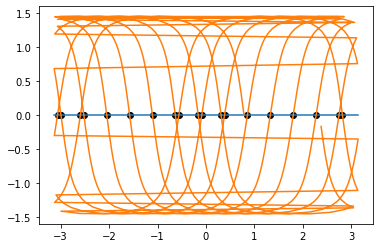

In [187]:
# centering a point at the equitorial line (a1,b1) each time we cross
for i in range(0,n):
    u1.append( x2[i] - x1[i] )
    v1.append( y2[i] - y1[i] )        

for i in range(0,n):
    a1.append( x1[i] - (u1[i]/v1[i])*y1[i] )
    b1.append( 0 )        

colors = (0,0,0)
plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(a1,b1,c=colors)
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])
plt.show()

In [188]:
# Using what Greg thinks should work
for i in range(0,np.size(theta)):
    swath_length.append( s / slope[i] )

IndexError: list index out of range

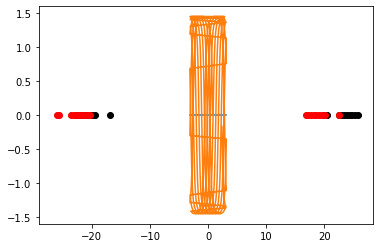

In [189]:
# Capturing the interval for each pass accross the equator
equator_catch_minus=[]
equator_catch_plus=[]
for i in range(0,n):
    equator_catch_plus.append( a1[i] + swath_length[i] )
    equator_catch_minus.append( a1[i] - swath_length[i] )
#print(equator_catch_plus,'\n')
#print(equator_catch_minus)

plt.plot([-np.pi,np.pi],[0,0])
plt.scatter(equator_catch_plus,b1,c='k')
plt.scatter(equator_catch_minus,b1,c='r')
for i in range(0,satellites):
    plt.plot(psi[i], phi[i])

In [171]:
# Comparing each interval we've crossed through periods and combining 
#     overlapping intervals. As well as offsetting the interval we've 
#         caught so instead of looking at [-pi,pi] we look at [0,2pi]
#       this should be easier to convert to a scale needed to compare
#                           with the equitorial coverage of the Earth

m = np.size(equator_catch_plus)
for i in range(0,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught1.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught1.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
for i in range(1,m,2):
    if(equator_catch_plus[i] <= equator_catch_minus[i]):
        interval_caught2.append( [ np.pi + equator_catch_plus[i], np.pi + equator_catch_minus[i] ] )
    else:
        interval_caught2.append( [ np.pi + equator_catch_minus[i], np.pi + equator_catch_plus[i] ] )
    
print(np.size(interval_caught1,0),interval_caught1,'\n')
print(np.size(interval_caught2,0),interval_caught2)
print('\n')

m1 = np.size(interval_caught1,0)
m2 = np.size(interval_caught2,0)
area_passed_over_eq1 = interval_caught1[0]
area_passed_over_eq2 = interval_caught2[0]

for i in range(1,m1):
    area_passed_over_eq1 = interval( area_passed_over_eq1 ) | interval( interval_caught1[i] )

for i in range(1,m2):
    area_passed_over_eq2 = interval( area_passed_over_eq2 ) | interval( interval_caught2[i] )
    
print(np.size(area_passed_over_eq1,0),area_passed_over_eq1)
print('\n')
print(np.size(area_passed_over_eq2,0),area_passed_over_eq2)

11 [[0.5477218972775355, 0.5919880686534165], [0.11662814227464713, 0.1609049132621494], [5.968733024555763, 6.012996349867738], [5.537641302962431, 5.581914503920991], [5.1065550869034055, 5.1508233137759944], [4.675470459345391, 4.7197351205524996], [4.244374306407597, 4.288655194021716], [3.813295193901724, 3.8575590648807507], [3.3822055060851492, 3.4264756846968187], [2.951116415554608, 2.995387246812606], [2.520033400838807, 2.56429709655077]] 

10 [[3.4767425824282867, 3.5150614111632303], [3.0456526802864237, 3.08398392635495], [2.614556897716005, 2.652895219023731], [2.1834831191579527, 2.2218000474911968], [1.752377601102662, 1.7907318004659247], [1.321303010464321, 1.3596251107835544], [0.8902179622728315, 0.9285435080624498], [0.4591157611147634, 0.4974625335665954], [0.02804526831049614, 0.0663616708375665], [5.880131070123412, 5.918475759082913]]


11 interval([0.11662814227464713, 0.1609049132621494], [0.5477218972775355, 0.5919880686534165], [2.520033400838807, 2.564297

In [172]:
# Post processing:
# We have a case where we go beyond the [0,2pi] range.
# This cell is fixing the left endpoint

# Setting tolerance in which we want to consider
#         the distance traveled beyond or domain
tol = -1e-10

# This checks the boolean of how negative the left end-point is
boo = tol in interval(area_passed_over_eq1[0])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    print('\n')
    area_passed_over_eq1 = coverage_correction_left(area_passed_over_eq1)
    print(area_passed_over_eq1)

print('\n')
boo = tol in interval(area_passed_over_eq2[0])
if( boo == True ):
    print('2\n')
    print(area_passed_over_eq2)
    print('\n')
    area_passed_over_eq2 = coverage_correction_left(area_passed_over_eq2)    
    print(area_passed_over_eq2)

In [173]:
# Now to fix the right endpoint if we go past 2*pi

# Post processing:
#    We have a case where we go beyond the [0,2pi] range.
tol = 1e-10

# This checks the boolean of how negative the left end-point is
boo = 2*np.pi + tol in interval(area_passed_over_eq1[-1])

if( boo == True ):
    print('1\n')
    print(area_passed_over_eq1)
    area_passed_over_eq1 = coverage_correction_right(area_passed_over_eq1)
    print('\n')
    print(area_passed_over_eq1)

print('\n')
boo = 2*np.pi + tol in interval(area_passed_over_eq2[-1])
if( boo == True ):
    print('1\n')
    print(area_passed_over_eq2)
    area_passed_over_eq2 = coverage_correction_right(area_passed_over_eq2)
    print('\n')
    print(area_passed_over_eq2)

In [174]:
# Now we convert this output in relation to the circumference of Earth -- 40,075 km
area_passed_over_eq1 = area_passed_over_eq1 * (R/1000) # convert to distance traveled in km
area_passed_over_eq2 = area_passed_over_eq2 * (R/1000) # convert to distance traveled in km
print('1 ',area_passed_over_eq1,'\n')
print('2 ',area_passed_over_eq2)

1  interval([743.0389207594287, 1025.1266183563905], [3489.5410275078743, 3771.5611948859205], [16055.154973037963, 16337.159367939405], [18801.588653322862, 19083.638508850883], [21548.061042676938, 21830.106740189458], [24294.537237345587, 24576.542748875036], [27040.946056616693, 27323.059981278064], [29787.463440629523, 30069.473986709036], [32533.907396346356, 32815.94065931202], [35280.361472417106, 35562.426425328274], [38026.85062429537, 38308.85265937524]) 

2  interval([178.67665120453202, 422.79078888883953], [2925.030554280855, 3169.3381790230746], [5671.586471558277, 5915.758861048738], [8418.03310713468, 8662.183545503], [11164.413117547947, 11408.76805920825], [13910.990166806763, 14155.107654406833], [16657.365003449366, 16901.61878587812], [19403.88002784839, 19648.088733865938], [22150.357587985338, 22394.48718306136], [37462.36679290967, 37706.66114370392])


<Figure size 432x288 with 0 Axes>

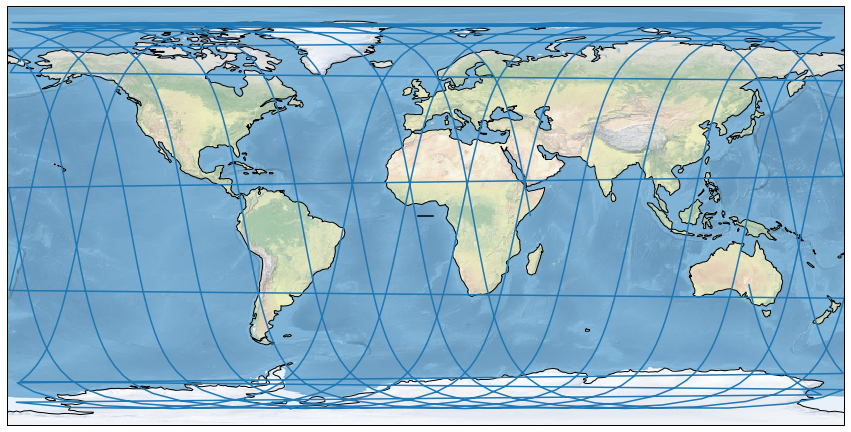

In [175]:
fig = plt.figure()
src_crs = ccrs.PlateCarree()
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(1,1,1)
ax = plt.axes(projection=src_crs)
ax.stock_img()
ax.coastlines()
ax.plot([-np.pi,np.pi],[0,0],'k')
for i in range(0,satellites):
    lon = psi[i] # [-pi,pi]
    lat = phi[i] # [-pi/2,pi/2]
    # converting to degrees
    lon = lon * (180/np.pi)
    lat = lat * (180/np.pi)
    ax.plot(lon,lat)